# Panda external load identification

In [1]:
%%capture
!pip3 install mediapy mujoco dm_control robot_descriptions matplotlib

In [2]:
import matplotlib.pyplot as plt
import mediapy as media
import mujoco
import numpy as np
from dm_control import mjcf
from robot_descriptions.panda_mj_description import MJCF_PATH

from scripts.utils import ActuatorMotor, update_actuator

np.random.seed(0)

# get path to panda without gripper
MJCF_PATH = MJCF_PATH[: -len("panda.xml")] + "panda_nohand.xml"

# Problem formulation

Assume that panda manipulator has grabbed an object with unknown mass and shift from the end-effector.

The goal is to identify the mass and shift of the object by making robot follow a set of configurations and measuring the change in the torque.

Then after the identification, we should compensate external load and update the control policy.

Free mass dynamics equation can be written as:

$$
M \dot{\tilde{v}} + \bar{v} \times M \bar{v} = \bar{f}
$$

Where $M \in R^{6x6}$ is the spacial inertia matrix of the body, $\bar{v} \in R^6$ is the spacial velocity of the body, $\bar{f} \in R^6$ is the external force applied to the body, and $\tilde{v} \in R^6$ is the acceleration of the body including the gravity.

As we want to identify only the mass and the shift, we have only 4 parameters: $m, mr_x, mr_y, mr_z$. Moreover, given we use only static poses ($\bar{v} = 0, \dot{\bar{v}} = 0$), the equation simplifies to:

$$
M a_g = \bar{f}
$$

Where $a_g$ is the acceleration due to gravity. It is given as $a_g = R^T \begin{bmatrix} 0 & 0 & 9.81 \end{bmatrix}^T$ where $R$ is the rotation matrix of the end-effector.

Linearly to the parameters, the equation can be written as:

$$\begin{bmatrix}a_1 & 0 & 0 & 0 \\ a_2 & 0 & 0 & 0 \\ a_3 & 0 & 0 & 0 \\ 0 & 0 & a_3 & -a_2 \\ 0 & -a_3 & 0 & a_1 \\ 0 & a_2 & -a_1 & 0\end{bmatrix} \begin{bmatrix}m \\ mr_x \\ mr_y \\ mr_z\end{bmatrix} = \bar{f}$$

$$
\mathbf{Y_b} \theta = \bar{f}
$$

where $a_1, a_2, a_3$ are the components of the acceleration due to gravity $a_g$.

Let us then consider the dynamics of the robot.

Without the external load, the dynamics of the robot can be written as:

$$
M(q) \ddot{q} + C(q, \dot{q}) \dot{q} + G(q) = \tau
$$

Where $M(q)$ is the mass matrix, $C(q, \dot{q})$ is the Coriolis matrix, $G(q)$ is the gravity vector, and $\tau$ is the torque applied to the robot.

We can find how the external force affects each joint by pre-multiplying the force by $J^T(q)$:

$$
M(q) \ddot{q} + C(q, \dot{q}) \dot{q} + G(q) = \tau + J^T(q) \bar{f}
$$

As we known the external force can be written as $\bar{f} = \mathbf{Y_b} \theta$, we can substitute it in the equation:

$$
M(q) \ddot{q} + C(q, \dot{q}) \dot{q} + G(q) = \tau + J^T(q) \mathbf{Y_b} \theta
$$

By finding the parameters $\theta$ that minimize the error, we can identify the mass and the shift of the object.
Then, we can compensate the external load by subtracting the external force from the torque.


In [3]:
# create a model with external load
mjcf_model = mjcf.from_path(MJCF_PATH, escape_separators=True)
# get the body of end-effector
ee_body = mjcf_model.find("body", "link7")
# create new body with offset from the end-effector
rc = np.array([0.1, 0.05, -0.1])
load_mass = ee_body.add("body", name="load_mass", pos=f"{rc[0]} {rc[1]} {rc[2]}")
load_mass.add("geom", name="load_mass_geom", type="sphere", size="0.05", rgba="0.8 0.2 0.2 1")

# add inertial properties to the new body
M = 2.0
I = 1e-6
load_mass.add("inertial", mass=f"{M}", pos="0 0 0", diaginertia=f"{I} {I} {I}")

# disable collision for all the geoms
for geom in mjcf_model.find_all("geom"):
    geom.conaffinity = 0
    geom.contype = 0

physics = mjcf.Physics.from_mjcf_model(mjcf_model)
sim_model = physics.model._model
sim_data = mujoco.MjData(sim_model)
renderer = mujoco.Renderer(sim_model, height=480, width=640)

# create an old model without the load mass
old_mjcf_model = mjcf.from_path(MJCF_PATH, escape_separators=True)
# disable collisions for all the geoms
for geom in old_mjcf_model.find_all("geom"):
    geom.conaffinity = 0
    geom.contype = 0

old_model = mjcf.Physics.from_mjcf_model(old_mjcf_model).model._model
old_data = mujoco.MjData(old_model)
body_offset = np.where(old_model.body_dofadr == 0)[0][0]

## Visualize the robot with the external load

""

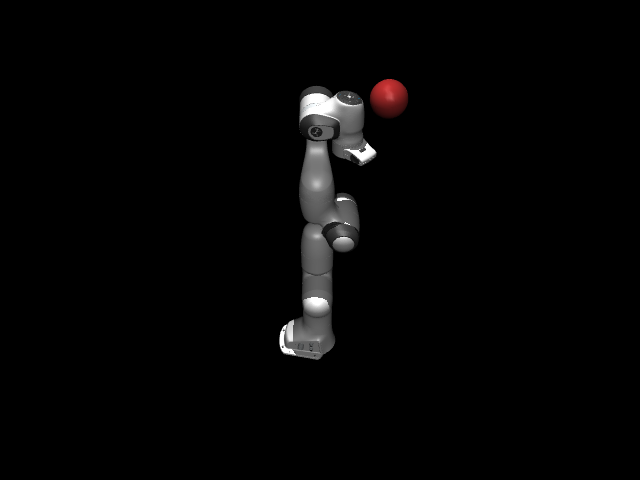

In [4]:
# Reset data, set initial pose.
mujoco.mj_resetData(sim_model, sim_data)

# Step the simulation.
mujoco.mj_step(sim_model, sim_data)

renderer.update_scene(sim_data)
media.show_image(renderer.render())

## Implementation of static load joint regressor

In [5]:
def staticload_joint_regressor(mj_model, mj_data, ee_id, active_joints=7, body_offset=0):
    accel = np.zeros(6)

    mujoco.mj_rnePostConstraint(mj_model, mj_data)
    mujoco.mj_objectAcceleration(mj_model, mj_data, 2, ee_id, accel, 1)
    rotation = mj_data.xmat[ee_id + body_offset].reshape(3, 3).copy()

    a1, a2, a3 = rotation.T @ np.array([0, 0, 9.81])  #

    static_load_regressor = np.array(
        [
            [a1, 0, 0, 0],
            [a2, 0, 0, 0],
            [a3, 0, 0, 0],
            [0, 0, a3, -a2],
            [0, -a3, 0, a1],
            [0, a2, -a1, 0],
        ]
    )

    jac_lin = np.zeros((3, mj_model.nv))
    jac_rot = np.zeros((3, mj_model.nv))
    mujoco.mj_jacBody(mj_model, mj_data, jac_lin, jac_rot, ee_id + body_offset)
    ee_local_jacobian = np.vstack(
        (
            rotation.T @ jac_lin[:, :active_joints],
            rotation.T @ jac_rot[:, :active_joints],
        )
    )
    joint_regressor = ee_local_jacobian.T @ static_load_regressor

    return joint_regressor

## Generate a sequence of waypoints to follow


In [6]:
for actuator_id in range(sim_model.nu):
    actuator = ActuatorMotor()
    update_actuator(sim_model, actuator_id, actuator)

# find limits except the last two fingers
lower, upper = np.zeros(sim_model.nq), np.zeros(sim_model.nq)
for jnt_idx in range(sim_model.nq):
    lower[jnt_idx] = sim_model.joint(jnt_idx).range[0]
    upper[jnt_idx] = sim_model.joint(jnt_idx).range[1]

num_of_phases = 3
waypoints = [np.random.uniform(lower, upper) for _ in range(num_of_phases)]

In [7]:
# define PD controller for inverse dynamics
kp = 50
kd = 10
target_q = waypoints[0]

frames = []
framerate = 25

phase_time = 5.0
phases = 0
old_data.time = 0
sim_data.time = 0

load_joint_regressor = np.zeros(((sim_model.nq) * num_of_phases, 4))
load_joint_force = np.zeros((sim_model.nq) * num_of_phases)
active_joints = sim_model.nq

hist_q = []
target_hist_q = []

while sim_data.time < (num_of_phases - 1) * phase_time:
    # PD controller
    mujoco.mj_step(sim_model, sim_data)

    hist_q.append(sim_data.qpos.copy())
    target_hist_q.append(target_q)

    target_acc = kp * (target_q - sim_data.qpos) + kd * (np.zeros(sim_model.nv) - sim_data.qvel)

    # use old data to solve inverse dynamics
    old_data.qpos = sim_data.qpos.copy()
    old_data.qvel = sim_data.qvel.copy()
    old_data.qacc = target_acc
    mujoco.mj_inverse(old_model, old_data)
    sol = old_data.qfrc_inverse

    sim_data.ctrl = sol

    if sim_data.time > phase_time * phases and phases < num_of_phases:
        # after each phase we add the regressor and the joint forces
        # and change the target q
        regressor = staticload_joint_regressor(old_model, old_data, old_data.body(ee_body.name).id).copy()
        load_joint_regressor[7 * phases : 7 * (phases + 1), :] = regressor

        load_qforce = sol[:7] - old_data.qfrc_bias[:7]
        load_joint_force[7 * phases : 7 * (phases + 1)] = load_qforce.copy()
        actual_load_qforce = regressor @ np.array([M, *(M * rc)])

        target_q = waypoints[phases]
        phases += 1

hist_q = np.array(hist_q)
target_hist_q = np.array(target_hist_q)

## Analyze the controller performance

We see that inverse dynamics controller meant to compensate the non-linear dynamics of the robot is not able to compensate the external load. We can see that the error is not zero, and the robot is not able to meet the desired waypoints.


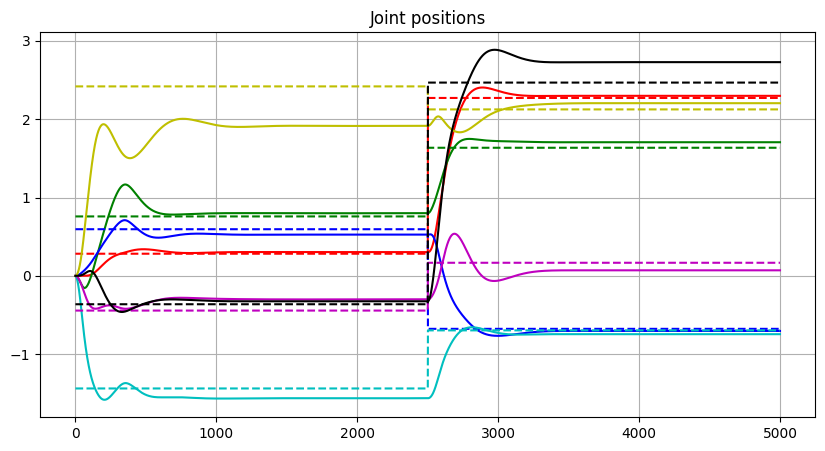

In [8]:
each_joint_color = ["r", "g", "b", "c", "m", "y", "k"]

plt.figure(figsize=(10, 5))
plt.title("Joint positions")
for jidx in range(7):
    plt.plot(hist_q[:, jidx], color=each_joint_color[jidx])
    plt.plot(target_hist_q[:, jidx], linestyle="--", color=each_joint_color[jidx])

plt.grid()
plt.show()

Now as we have gathered the data, we can stack regressors and solve the least squares problem to identify the mass and the shift of the object.

$$
\begin{bmatrix}
\mathbf{Y_1} \\
\mathbf{Y_2} \\
\vdots \\
\mathbf{Y_n}
\end{bmatrix} \theta = \begin{bmatrix}
\bar{f_1} \\
\bar{f_2} \\
\vdots \\
\bar{f_n}
\end{bmatrix}
$$


## Actual parameters

In [9]:
M, rc

(2.0, array([ 0.1 ,  0.05, -0.1 ]))

## Pseudo-inverse method


In [10]:
params_estimates = np.linalg.pinv(load_joint_regressor[7:, :]) @ load_joint_force[7:]
mass = params_estimates[0]
coordinate = params_estimates[1:] / mass
mass, coordinate

(2.0000108701382255, array([ 0.09999891,  0.05000309, -0.09999559]))

## Non-linear least squares method

In [11]:
import mujoco.minimize as minimize

result = minimize.least_squares(
    np.ones(4),
    lambda x: (load_joint_regressor[7:] @ x - load_joint_force[7:]) ** 2,
)
estimates = result[0]
mass = estimates[0]
coordinate = estimates[1:] / mass
mass, coordinate

iter: 0    y: 1.078e+05  log10mu: -inf  ratio: 0.94     dx: 0.99     reduction: 1e+05  
iter: 1    y: 6737       log10mu: -inf  ratio: 0.94     dx: 0.49     reduction: 6.3e+03
iter: 2    y: 421        log10mu: -inf  ratio: 0.94     dx: 0.25     reduction: 3.9e+02
iter: 3    y: 26.31      log10mu: -inf  ratio: 0.94     dx: 0.12     reduction: 25     
iter: 4    y: 1.645      log10mu: -inf  ratio: 0.94     dx: 0.062    reduction: 1.5    
iter: 5    y: 0.1028     log10mu: -inf  ratio: 0.94     dx: 0.031    reduction: 0.096  
iter: 6    y: 0.006425   log10mu: -inf  ratio: 0.94     dx: 0.015    reduction: 0.006  
iter: 7    y: 0.0004015  log10mu: -inf  ratio: 0.94     dx: 0.0077   reduction: 0.00038
iter: 8    y: 2.51e-05   log10mu: -inf  ratio: 0.94     dx: 0.0039   reduction: 2.4e-05
iter: 9    y: 1.569e-06  log10mu: -inf  ratio: 0.94     dx: 0.0019   reduction: 1.5e-06
iter: 10   y: 9.806e-08  log10mu: -inf  ratio: 0.94     dx: 0.00096  reduction: 9.2e-08
iter: 11   y: 6.131e-09  log10mu

(2.00001467598306, array([ 0.0999989 ,  0.05000306, -0.09999331]))

# Now we can update the controller to compensate the external load

Along with the inverse dynamics controller, we can add a feedforward term to compensate the external load.

$$
\tau = \tau_{ID} - J^T(q) \mathbf{Y_b} \theta
$$


In [12]:
# define PD controller for inverse dynamics
kp = 50
kd = 10
target_q = waypoints[0]

frames = []
framerate = 25

phase_time = 5.0
phases = 0
old_data.time = 0
sim_data.time = 0

load_joint_regressor = np.zeros(((sim_model.nq) * num_of_phases, 4))
load_joint_force = np.zeros((sim_model.nq) * num_of_phases)
active_joints = sim_model.nq

hist_q_new = []
target_hist_q_new = []

while sim_data.time < (num_of_phases - 1) * phase_time:
    # PD controller
    mujoco.mj_step(sim_model, sim_data)

    hist_q_new.append(sim_data.qpos.copy())
    target_hist_q_new.append(target_q)

    target_acc = kp * (target_q - sim_data.qpos) + kd * (np.zeros(sim_model.nv) - sim_data.qvel)

    # use old data to solve inverse dynamics
    old_data.qpos = sim_data.qpos.copy()
    old_data.qvel = sim_data.qvel.copy()
    old_data.qacc = target_acc
    mujoco.mj_inverse(old_model, old_data)
    sol = old_data.qfrc_inverse

    body_params = np.array([M, *(M * rc)])
    actual_load_qforce = (
        staticload_joint_regressor(old_model, old_data, old_data.body(ee_body.name).id).copy() @ body_params
    )

    sim_data.ctrl = sol + actual_load_qforce

    if sim_data.time > phase_time * phases and phases < num_of_phases:
        target_q = waypoints[phases]
        phases += 1

hist_q_new = np.array(hist_q_new)
target_hist_q_new = np.array(target_hist_q_new)

# Analyze the updated controller performance

We can see that even so the robot takes some time to converge to the desired waypoints, it is able to compensate the external load and meet the desired waypoints with a smaller error.


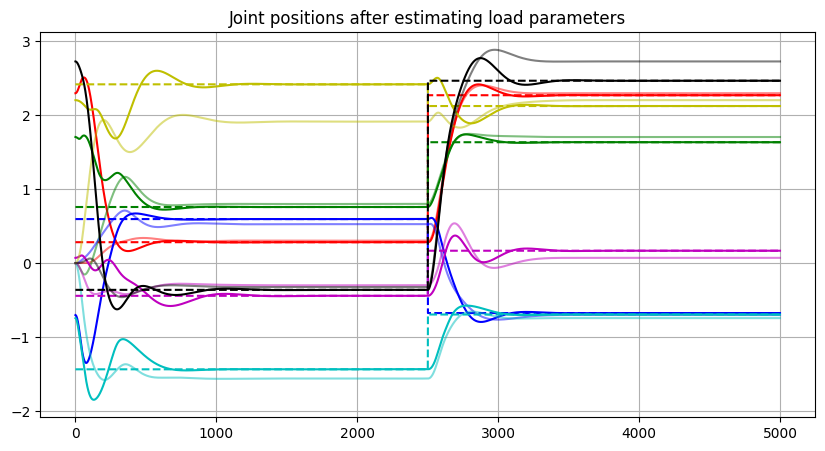

In [13]:
plt.figure(figsize=(10, 5))
plt.title("Joint positions after estimating load parameters")
for jidx in range(7):
    plt.plot(hist_q_new[:, jidx], color=each_joint_color[jidx])
    plt.plot(target_hist_q_new[:, jidx], linestyle="--", color=each_joint_color[jidx])
    plt.plot(hist_q[:, jidx], color=each_joint_color[jidx], alpha=0.5)

plt.grid()
plt.show()

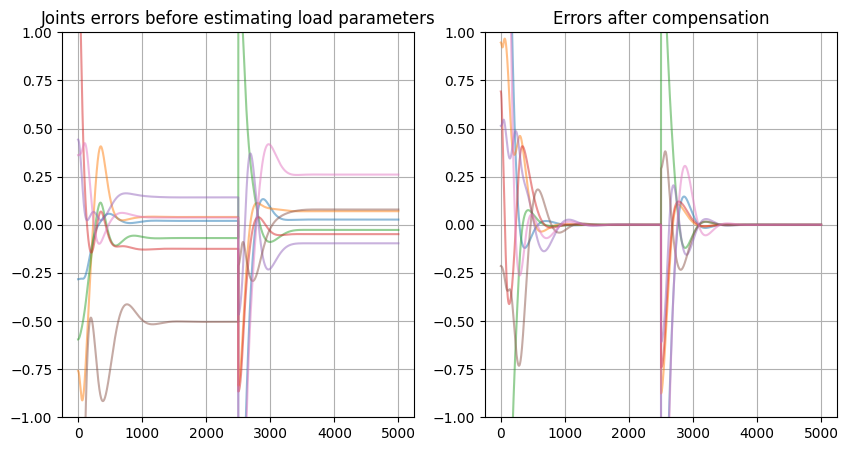

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_title("Joints errors before estimating load parameters")
ax[0].plot(hist_q - target_hist_q, alpha=0.5)
ax[0].set_ylim(-1, 1)
ax[0].grid()

ax[1].set_title("Errors after compensation")
ax[1].plot(hist_q_new - target_hist_q_new, alpha=0.5)
ax[1].set_ylim(-1, 1)
ax[1].grid()